### Install Required Libs

In [ ]:
# only local run: install required libs (recommended python version 3.10)خب
%pip install numpy
%pip install matplotlib
%pip install torch torchvision torchaudio tqdm

### Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Functions
import torch.optim as Optimizers

from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

### Set Device
You can use GPU instead of CPU for faster calculation!

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Download CIFAR-10 Dataset and Transform to Tensor

In [3]:
transform = ToTensor()

"Set download=True to download dataset online"
data_path = './data_'
mnist_train = FashionMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = FashionMNIST(data_path, train=False, download=True, transform=transform)

### A Brief View on Data

In [4]:
# size of training and test sets
print("Training: ", len(mnist_train))
print("Testing: ", len(mnist_test))

# type of train and test: it is a collection of tuple(tensor, label)
print(type(mnist_train[0]))

# label, as you know, is the class of image
# tensor contains image data (You will learn more about Tensor later)
image, label = mnist_train[0]
print(type(image))

# lets check the dimension - it is a 28x28 RGB image
print(image.shape)

# lets see what classes we have
classes = mnist_train.classes
print(classes)
print(label)
print(classes[label])

Training:  60000
Testing:  10000
<class 'tuple'>
<class 'torch.Tensor'>
torch.Size([1, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
9
Ankle boot


### Define Batch Size
It is important to understand that to build the Neural Network we will work with a large number of parameters. For this reason, it makes sense to load training data in batches.

In [5]:
# TODO: Set a proper batch size
batch_size = 32  # Adjust based on available memory

# Define DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Example of loading a batch
for images, labels in train_loader:
    # Training code would go here
    print("Loaded batch of images:", images.shape)
    print("Loaded batch of labels:", labels.shape)
    break  # Remove this break in actual training loop


Loaded batch of images: torch.Size([32, 1, 28, 28])
Loaded batch of labels: torch.Size([32])


### Define Model
Here you need to define your model architecture, use your knowledge of ANN to design one.

In [6]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output: (32, 28, 28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Output: (64, 28, 28)
        
        # Pooling layers
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Halves the size: (32, 14, 14)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)  # Halves the size again: (64, 7, 7)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened size from pooled conv layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes
        
    def forward(self, x):
        x = F.relu(self.conv1(x))           # Convolution layer 1 output: (32, 28, 28)
        x = self.max_pool(x)                # Max pooling: (32, 14, 14)
        
        x = F.relu(self.conv2(x))           # Convolution layer 2 output: (64, 14, 14)
        x = self.avg_pool(x)                # Average pooling: (64, 7, 7)
        
        x = x.view(-1, 64 * 7 * 7)          # Flatten the tensor
        x = F.relu(self.fc1(x))             # Fully connected layer
        x = self.fc2(x)                     # Output logits (no softmax)
        
        return x


### Create Model

In [7]:
model = Model().to(device)
model

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Choose a Loss Function

In [8]:
"TODO: set a proper loss function"
criterion = torch.nn.CrossEntropyLoss()

### Choose an Optimizer

In [9]:
"TODO: set a proper optimizer"
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training Model
After configuring all required parameters, it is time to train your model!

In [10]:
"TODO: set an optimal epoch"
EPOCHS = 12

" you don't need to change the rest of this code"

train_correct  = []
test_correct = []

best_train_acc = 0
best_test_acc = 0

for e in tqdm(range(EPOCHS)):

  trn_corr = 0
  tst_corr = 0

  # training
  model.train()
  for X_train, y_train in train_loader:

    X_train_dev = torch.autograd.Variable(X_train).to(device)
    y_train_dev = torch.autograd.Variable(y_train).to(device)

    optimizer.zero_grad()

    y_pred_dev = model(X_train_dev)
    loss = criterion(y_pred_dev, y_train_dev)

    loss.backward()
    optimizer.step()

    predicted = torch.argmax(y_pred_dev, 1)
    trn_corr += torch.sum(predicted == y_train_dev)

  acc = (trn_corr/len(mnist_train)).item()
  best_train_acc = acc if(best_train_acc < acc) else best_train_acc
  train_correct.append(acc)

  # testing
  model.eval()
  for X_test, y_test in test_loader:

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    predicted = model(X_test)
    predicted = torch.argmax(predicted, 1)
    tst_corr += torch.sum(predicted == y_test)

  acc = (tst_corr/len(mnist_test)).item()
  best_test_acc = acc if(best_test_acc < acc) else best_test_acc
  test_correct.append(acc)

  0%|          | 0/12 [00:00<?, ?it/s]

### Evaluation
Here you can see your model performance.

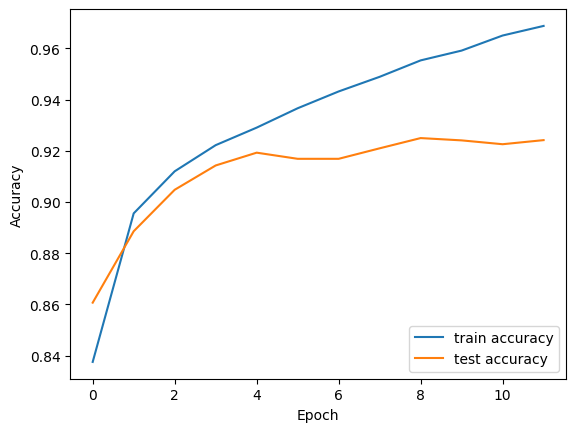


On train - best accuracy: 0.97, final accuracy: 0.97
On test - best accuracy: 0.93, final accuracy: 0.92


In [11]:
plt.plot(train_correct, label='train accuracy')
plt.plot(test_correct, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_correct[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_correct[-1]))